In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
def get_data():
    # Load data from BigQuery
    # Run pip install pandas-gbq if not installed
    
    sql = """
        SELECT 
            UPPER(contents) contents,
            UPPER(topic_item) topic_item
        FROM `jbencina-144002.doj.press_releases`, UNNEST(topics) topic_item 
        where array_length(topics)>0
    """
    
    return pd.read_gbq(sql, dialect='standard')

df = get_data()
df.head()

,contents,topic_item
0,THE FORMER TAX PREPARER FOR TELEVISION PERSONA...,TAX
1,UBS AG HAS COMPLIED WITH AN INTERNAL REVENUE S...,TAX
2,"TWO MEN WHO CONSPIRED TO FILE MORE THAN 1,200 ...",TAX
3,"WASHINGTON - JEFFERY LEON CEASER, A RESIDENT O...",TAX
4,FILED MORE THAN 335 FALSE TAX RETURNS SEEKING ...,TAX


In [146]:
def show_sample(data, samples, max_len):
    for i,v in data.sample(samples).contents.str[:max_len].iteritems():
        print('\n' + v)
        
show_sample(df, 5, 500)


A LICENSED PHARMACIST WAS SENTENCED TODAY TO 78 MONTHS IN PRISON FOR ATTEMPTING TO WEAPONIZE THE LETHAL TOXINS RICIN AND ABRIN AND FOR POSSESSING A PROHIBITED FLASK INTENDING TO USE IT TO MANUFACTURE ILLEGAL NARCOTICS, U.S. ATTORNEY PAUL J. FISHMAN FOR THE DISTRICT OF NEW JERSEY ANNOUNCED. JORDAN GONZALEZ, 34, OF NEW YORK, FORMERLY OF JERSEY CITY, NEW JERSEY, PREVIOUSLY PLEADED GUILTY BEFORE U.S. DISTRICT JUDGE MARY L. COOPER TO AN INFORMATION CHARGING HIM WITH THE OFFENSES. “THE SENTENCE IMPOSE

TWO ASSOCIATES ALSO SENTENCED FOR THEIR ROLES IN THE CONSPIRACY THE OWNER OF A FLORIDA MORTGAGE COMPANY WAS SENTENCED TODAY TO SERVE 135 MONTHS IN PRISON FOR ORCHESTRATING A $64 MILLION MORTGAGE FRAUD SCHEME. ASSISTANT ATTORNEY GENERAL LESLIE R. CALDWELL OF THE JUSTICE DEPARTMENT’S CRIMINAL DIVISION, U.S. ATTORNEY WIFREDO A. FERRER OF THE SOUTHERN DISTRICT OF FLORIDA AND SPECIAL AGENT IN CHARGE NADINE GURLEY OF THE U.S. DEPARTMENT OF HOUSING AND URBAN DEVELOPMENT OFFICE OF INSPECTOR GENERAL (

## Show top N topics

In [373]:
top_topics = df.topic_item.value_counts()[:20]
top_topics

TAX                                       863
CIVIL RIGHTS                              428
CONSUMER PROTECTION                       402
HEALTH CARE FRAUD                         327
ANTITRUST                                 313
HATE CRIMES                               290
COUNTERTERRORISM                          260
STOPFRAUD                                 253
FALSE CLAIMS ACT                          240
ENVIRONMENT                               220
NATIONAL SECURITY                         210
PROJECT SAFE CHILDHOOD                    179
PUBLIC CORRUPTION                         172
IDENTITY THEFT                            129
FINANCIAL FRAUD                           128
VIOLENT CRIME                             119
CYBER CRIME                               100
COUNTERINTELLIGENCE AND EXPORT CONTROL     95
IMMIGRATION                                85
HUMAN TRAFFICKING                          84
Name: topic_item, dtype: int64

## Get first N words and top K topics
- Discard anything after Nth word

In [461]:
n_words = 1000
n_topics = 20
n_vocab = 5000

def get_inputs(data, n_words, k_topics):
    df = pd.get_dummies(data.set_index(data.contents.str[:n_words])).groupby(level=0).max()
    top_topics = df.sum(axis=0).nlargest(k_topics).index.values

    features = df.index.values
    labels = df[top_topics].values
    
    return features, labels

features, labels = get_inputs(df, n_words, n_topics)

In [462]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import LSTM, Embedding, Dense, CuDNNLSTM, Bidirectional, Dropout
from keras.optimizers import Adam, Adagrad
from keras.callbacks import EarlyStopping
from keras.metrics import top_k_categorical_accuracy
from sklearn.model_selection import train_test_split

# Prepare data

## Train test split

In [463]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=10)

## Convert to sequences
- Choose top N words, converting others to UNK
- Pad all sequences to a minimum length if they happen to be shorter

In [464]:
def text_to_seq(x_train, x_test, max_len, num_words):
    t = Tokenizer(num_words=num_words, oov_token='<UNK>')
    t.fit_on_texts(x_train)
    train_seq = t.texts_to_sequences(x_train)
    train_pad = pad_sequences(train_seq, maxlen=max_len)

    test_seq = t.texts_to_sequences(x_test)
    test_pad = pad_sequences(test_seq, maxlen=train_pad.shape[1])
    
    return train_pad, test_pad, {k: t.word_index.get(k,0) for k in ['<PAD>'] + list(t.word_index)[:num_words-1]}, t

train_pad, test_pad, vocab, t = text_to_seq(x_train, x_test, n_words, n_vocab)

## Load pretrained word embeddings
- Load Glove 50D
- Select only the words in our vocab
- Missing words become NA
- NAs are filled with random values computed for each column
- Final weights is equal to nwords x embedding size (n_words includes PAD & UNK)

In [465]:
def load_glove(path, vocab):
    df = pd.read_table(path, index_col=0, header=None, sep=' ', quoting=3, na_values=None, keep_default_na=False)
    df.columns = [c for c in range(df.shape[1])]
    
    # Limit Glove to our vocab and fill in missing words from normal distribution
    col_means = glove.mean()
    col_std = glove.std()
    word_vec = glove.reindex([k for k in vocab])

    for i,col in enumerate(word_vec.columns):
        vals = word_vec[col].values
        mask = word_vec[col].isna()
        rand_vals = np.random.normal(col_means[i], col_std[i], size=sum(mask))
        vals[mask] = rand_vals

    return word_vec
    
glove = load_glove('glove.6B.100d.txt', vocab)

## Create RNN model
- Pass squences through embedding (CuDNNLSTM doesn't support masking) with pretrained weights
- Single layer LSTM + extra dense layer
- Early stopping after 5 epochs

In [466]:
model = Sequential([
    Embedding(glove.shape[0], glove.shape[1], input_length=train_pad.shape[1], mask_zero=False, weights=[glove.values]),
    Bidirectional(CuDNNLSTM(128, return_sequences=False)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(n_topics, activation='sigmoid')
])

optimizer = Adam(lr=0.001)
es = EarlyStopping(patience=5)

def top_k(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [467]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 1000, 50)          250000    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               184320    
_________________________________________________________________
dense_64 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 20)                660       
Total params: 443,204
Trainable params: 443,204
Non-trainable params: 0
_________________________________________________________________


In [468]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[top_k])
train_history = model.fit(x=train_pad, y=y_train, batch_size=32, 
                          validation_data=(test_pad, y_test), epochs=100, verbose=2, callbacks=[es])

Train on 3748 samples, validate on 938 samples
Epoch 1/100
 - 12s - loss: 0.2627 - top_k: 0.2030 - val_loss: 0.1900 - val_top_k: 0.3817
Epoch 2/100
 - 10s - loss: 0.2000 - top_k: 0.2820 - val_loss: 0.1745 - val_top_k: 0.3529
Epoch 3/100
 - 10s - loss: 0.1851 - top_k: 0.3071 - val_loss: 0.1664 - val_top_k: 0.3763
Epoch 4/100
 - 10s - loss: 0.1763 - top_k: 0.3428 - val_loss: 0.1602 - val_top_k: 0.4030
Epoch 5/100
 - 10s - loss: 0.1672 - top_k: 0.3991 - val_loss: 0.1529 - val_top_k: 0.4797
Epoch 6/100
 - 10s - loss: 0.1659 - top_k: 0.4176 - val_loss: 0.1481 - val_top_k: 0.4861
Epoch 7/100
 - 10s - loss: 0.1553 - top_k: 0.4800 - val_loss: 0.1366 - val_top_k: 0.5437
Epoch 8/100
 - 10s - loss: 0.1415 - top_k: 0.5467 - val_loss: 0.1249 - val_top_k: 0.6205
Epoch 9/100
 - 10s - loss: 0.1301 - top_k: 0.5920 - val_loss: 0.1186 - val_top_k: 0.6482
Epoch 10/100
 - 10s - loss: 0.1166 - top_k: 0.6574 - val_loss: 0.1025 - val_top_k: 0.7079
Epoch 11/100
 - 10s - loss: 0.1162 - top_k: 0.6395 - val_loss:

## Plot Loss

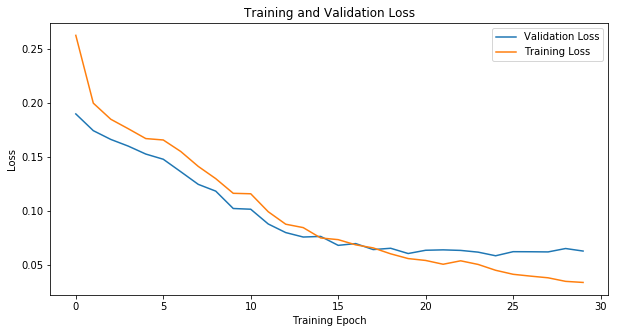

In [469]:
def plot_loss(history):
    %matplotlib inline
    
    f, ax = plt.subplots(1, figsize=(10,5))
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['loss'], label='Training Loss')
    ax.set_title('Training and Validation Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Training Epoch')
    ax.legend()
    
plot_loss(train_history.history)

## Generate sample predictions

In [492]:
import numpy as np
def make_random_pred(model, x, x_true, y, topics):
    idx = np.random.randint(0,x.shape[0])
    
    y_pred = model.predict(x[idx].reshape(1,-1))
    y_pred_topic = ','.join(topics[y[idx].astype(bool)])
    
    preds = list(sorted(zip(y_pred[0], topics), key=lambda x: -x[0]))
    print('Model Predictions')
    print('\n'.join(['{:.2%} - {}'.format(s,t) for s,t in preds]))
    print('\nTrue Label(s): {}'.format('Other (Not In Model)' if y_pred_topic=='' else y_pred_topic))
    print('\nSample Text:\n' + x_true[idx])
    
    
make_random_pred(model, test_pad, x_test, y_test, top_topics.index.values)
    

Model Predictions
0.06% - VIOLENT CRIME
0.03% - CONSUMER PROTECTION
0.00% - FINANCIAL FRAUD
0.00% - IMMIGRATION
0.00% - STOPFRAUD
0.00% - ENVIRONMENT
0.00% - HUMAN TRAFFICKING
0.00% - CIVIL RIGHTS
0.00% - PUBLIC CORRUPTION
0.00% - HATE CRIMES
0.00% - NATIONAL SECURITY
0.00% - IDENTITY THEFT
0.00% - HEALTH CARE FRAUD
0.00% - CYBER CRIME
0.00% - PROJECT SAFE CHILDHOOD
0.00% - FALSE CLAIMS ACT
0.00% - COUNTERTERRORISM
0.00% - COUNTERINTELLIGENCE AND EXPORT CONTROL
0.00% - TAX
0.00% - ANTITRUST

True Label(s): Other (Not In Model)

Sample Text:
TODAY ATTORNEY GENERAL JEFF SESSIONS ISSUED A MEMO FOR THE ACTING ADMINISTRATOR OF THE DRUG ENFORCEMENT ADMINISTRATION DIRECTING THE DEA TO EVALUATE AND CONSIDER WHETHER OR NOT TO AMEND ITS REGULATIONS GOVERNING THE AGGREGATE PRODUCTION QUOTA WHERE APPROPRIATE AS EXPEDITIOUSLY AS PRACTICABLE, INCLUDING THROUGH A POTENTIAL INTERIM FINAL RULE. THIS IS IN RESPONSE TO STUDIES INDICATING THAT THE UNITED STATES IS AN OUTLIER IN THE NUMBER OF OPIOID PRESCR